<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_12/s12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"
!pip install --quiet "gradio"

Cloning into 'ERA_V1'...
remote: Enumerating objects: 1028, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 1028 (delta 89), reused 54 (delta 17), pack-reused 821
Receiving objects: 100% (1028/1028), 18.11 MiB | 14.15 MiB/s, done.
Resolving deltas: 100% (534/534), done.
fatal: not a git repository (or any of the parent directories): .git
Cloning into 'dl_hub'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 150 (delta 74), reused 106 (delta 37), pack-reused 0
Receiving objects: 100% (150/150), 27.68 KiB | 9.23 MiB/s, done.
Resolving deltas: 100% (74/74), done.
fatal: not a git repository (or any of the parent directories): .git
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

Add all the imports:

In [2]:
from __future__ import print_function
import os
import sys
from typing import Any
sys.path.append("dl_hub")
sys.path.append("ERA_V1/session_12")
import torch
import pandas as pd
import seaborn as sn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import seed_everything
from dl_hub.models.custom_resnet import CustomResnet, model_summary
from dl_hub.dataloaders.pl_custom_cifar10_datamodule import CustomCifar10DataModule
from dl_hub.models.pl_custom_resnet import LitResnet
from dl_hub.utils.helper_utils import find_best_lr, model_summary, get_incorrect_predictions, generate_grad_cam_visualizations
from dl_hub.utils.vis_utils import show_incorrect_predictions, plot_statistics, plot_losses, plot_accuracy, plot_lr_values, show_incorrect_predictions, plot_image_grid, preview_images, print_train_log
from dl_hub.PL_main import define_pl_model_resnet, build_data_module, train_and_eval_pl_model, get_max_lr


/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

Define all the Dataset related parameters

In [3]:
GLOBAL_SEED = 42
seed_everything(GLOBAL_SEED)
params = {}
train_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    A.transforms.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
    AA.crops.transforms.RandomCrop(height=32, width=32, always_apply=True),
    A.HorizontalFlip(),
    AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1,
                                            max_height=8,
                                            max_width=8,
                                            min_holes = 1,
                                            min_height=8,
                                            min_width=8,
                                            fill_value=(0.491, 0.482, 0.447),
                                            mask_fill_value = None),
    ToTensorV2()])
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    ToTensorV2(),])
val_transforms = test_transforms

params['train_transforms'] = train_transforms
params['val_transforms'] = val_transforms
params['test_transforms'] = test_transforms
params['val_split'] = 0.1
params['batch_size'] = 512 if torch.cuda.is_available() else 64
params['data_dir'] = os.environ.get("PATH_DATASETS", ".")
params['save_dir'] = "logs/"

# Define data module
cifar10_dm = build_data_module(params)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_fabric.utilities.seed:Global seed set to 42


100%|██████████| 170498071/170498071 [00:05<00:00, 29597089.84it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Define all the Model related parameters

  0%|          | 0/200 [00:00<?, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.55E-02


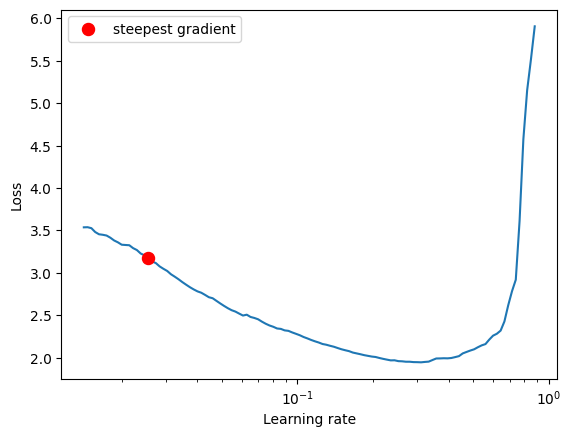

In [4]:
params['base_lr'] = 0.01
params['base_channels'] = 3
params['num_classes'] = 10
params['drop_out_probability'] = 0.1
params['loss_func'] = F.nll_loss
params['num_workers'] = 2
params['num_epochs'] = 24
params['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_params = {
    'weight_decay': 1e-4,
    'lr': 0.01,
    'momentum': 0.9
}
params['optimizer_type'] = 'Adam'
params['optimizer_params'] = optimizer_params
max_lr = get_max_lr(params, cifar10_dm)

steps_per_epoch = len(cifar10_dm.train_dataset) // params['batch_size']
scheduler_params = {
    'max_lr': max_lr,
    'num_steps_per_epoch': steps_per_epoch,
    'epochs': params['num_epochs'],
    'pct_start': 5./params['num_epochs'],
    'div_factor': 2000,
    'three_phase': False,
    'final_div_factor':1,
    'anneal_strategy':'linear',
}
params['scheduler_type'] = 'OneCycleLR'
params['scheduler_params'] = scheduler_params

Define Resnet Model in Pytorch Lightning

In [5]:
# Define model
resnet_model = define_pl_model_resnet(params)
# Print Model Summary
model_summary(resnet_model, input_size = (3,32,32))

Layer (type:depth-idx)                        Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
LitResnet                                     --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─CustomResnet: 1-1                           --                        --                        --                        --                        --
│    └─Sequential: 2-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    │    └─BatchNorm2d: 3-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    │    └─ReLU: 3-3                         --                   

Train and test the model

In [6]:
# train and eval model
trainer = train_and_eval_pl_model(params, resnet_model, cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResnet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2088` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9283999800682068     │
│         test_loss         │    0.2222578376531601     │
└───────────────────────────┴───────────────────────────┘

Plot Model Metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,train_loss,train_acc,val_loss,val_acc
step,,,,
0,NaN,NaN,NaN,NaN
0,2.968026,0.085938,NaN,NaN
1,NaN,NaN,NaN,NaN
1,2.760630,0.095703,NaN,NaN
2,NaN,NaN,NaN,NaN


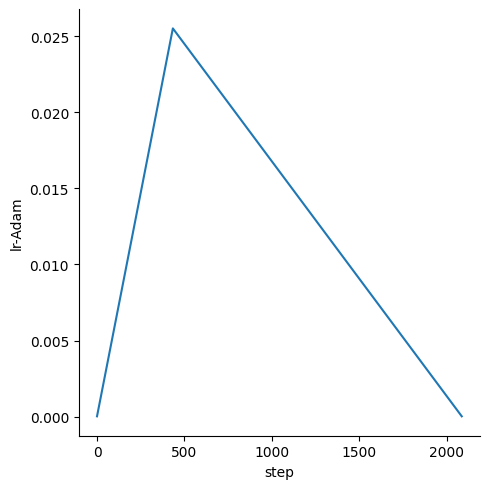

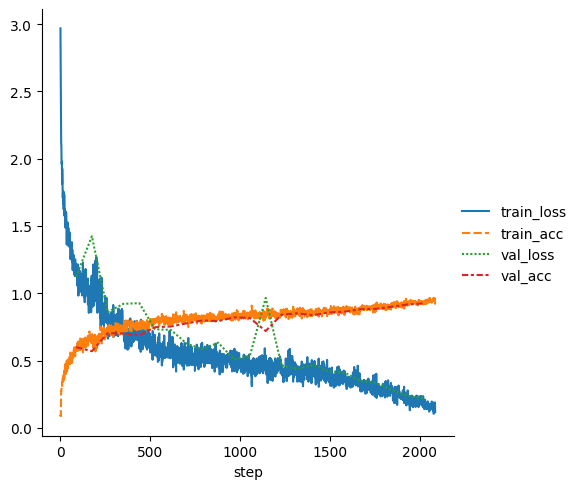

In [7]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["epoch"]
metrics.set_index("step", inplace=True)
sn.relplot(data=metrics['lr-Adam'], kind="line")
del metrics['lr-Adam'],metrics['test_acc'],metrics['test_loss']
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")


Show Incorrect Predictions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


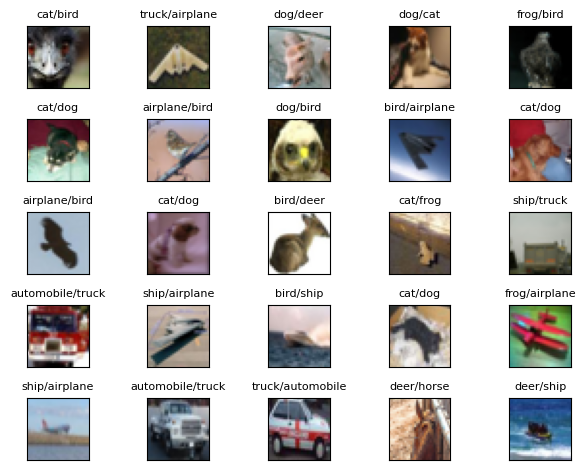

In [8]:
class_names = {"0": "airplane",
               "1": "automobile",
               "2": "bird",
               "3": "cat",
               "4": "deer",
               "5": "dog",
               "6": "frog",
               "7": "horse",
               "8": "ship",
               "9": "truck"}
num_rows = 5
num_cols = 5
test_loader = DataLoader(cifar10_dm.test_dataset, batch_size=params['batch_size'], num_workers=2, shuffle=False)
incorrect_predictions = get_incorrect_predictions(resnet_model.to(params['device']), test_loader, params['device'])
show_incorrect_predictions(incorrect_predictions, class_names, num_rows, num_cols)

Grad CAM Visualization of incorrect predictions

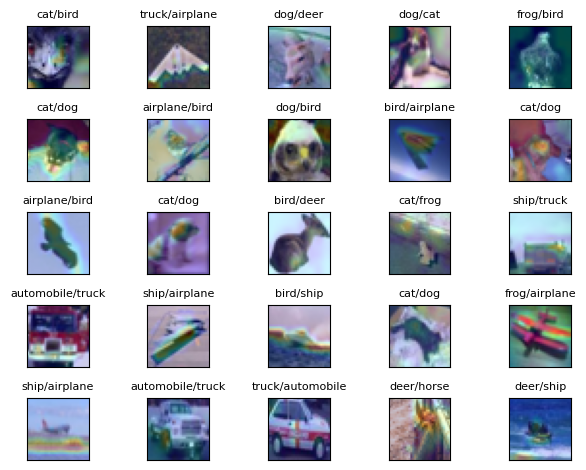

In [9]:
target_layers = [resnet_model.model.layer_2[-1]]
num_rows = 5
num_cols = 5
num_images_to_compute = num_rows*num_cols
grad_cam_map_list, prediction_list, ground_truth_list = generate_grad_cam_visualizations(resnet_model, target_layers, incorrect_predictions, class_names, num_images_to_compute=num_images_to_compute, image_weight=0.8)
plot_image_grid(grad_cam_map_list, prediction_list, ground_truth_list, num_rows, num_cols)

Save the Model

In [10]:
torch.save(resnet_model.state_dict(), "custom_resnet_model.pth")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Load the saved model so we can run inference

In [12]:
loss_func = params['loss_func']
base_lr = params['base_lr']
base_channels = params['base_channels']
num_classes = params['num_classes']
drop_out_probability = params['drop_out_probability']
num_epochs = params['num_epochs']
inference_model = LitResnet(loss_func, lr=base_lr,base_channels=base_channels, num_classes=num_classes,
                    drop_out_probability=drop_out_probability, epochs=num_epochs)

inference_model.load_state_dict(torch.load("custom_resnet_model.pth"), strict=False)

<All keys matched successfully>

Add UI for Grad CAM Visualization

In [13]:
!pip install --quiet "gradio"
import numpy as np
import gradio as gr
from PIL import Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.5 MB/s eta 0:

In [14]:
!pip install --quiet "gradio"
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM
from torchvision import transforms
from dl_hub.utils.helper_utils import un_normalize_image
from pytorch_grad_cam.utils.image import show_cam_on_image


def inference(model, device, target_layers, input_image, targets=None , image_weight=0.2):
    transform = transforms.ToTensor()
    input_tensor = transform(input_image)
    input_tensor = input_tensor.to(device)
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grad_cam_output = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
    grad_cam_output = grad_cam_output[0,:]
    un_norm_image = un_normalize_image(input_tensor.squeeze())
    un_norm_image_np = np.asarray(un_norm_image).transpose((1,2,0))
    grad_cam_map = show_cam_on_image(un_norm_image_np, grad_cam_output, use_rgb=True, image_weight = image_weight)
    return grad_cam_map


target_layers = [resnet_model.model.layer_2[-1]]
device = params['device']
demo = gr.Interface(inference, [inference_model, device, target_layers, gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])
demo.launch()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-14-314f4ecae4e5>:28: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  demo = gr.Interface(inference, [inference_model, device, target_layers, gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])


ValueError: ignored